In [140]:
import scipy.io as sio
from scipy.signal import welch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import operator
from functools import reduce
import pandas as pd
import pylab
from glob import glob
from functools import partial
from math import ceil
from os.path import split, splitext

%matplotlib inline
pylab.rcParams['figure.figsize'] = (18, 8)

Calculamos la máxima frecuencia de sampleo necesaria para no perder información

In [187]:
def loadSubject(filename):
    return sio.loadmat(filename)['data']

def allSubjects():
    return sorted(glob('dataset/*'))

data = loadSubject('dataset/P01.mat')
# epoch, electrodo, muestra
cant_muestras = len(data[0, 0])
cant_electrodos = len(data[0])
long_epoch = 0.8  # segundos
nfft = 2047
longitud_de_poderes = ceil(nfft / 2)
bandas = [0, 4, 8, 13, 30, 45]
nombre_bandas = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

# Redefino welch para que siempre tenga el mismo nfft
welch_eeg = partial(welch, fs=90, nfft=nfft)

In [98]:
electrodos = [8, 44, 80, 131, 185]

frecuencias, _ = welch(data[0, 0], fs=frecuencia_de_sampleo)

def heatmap(desde=0, hasta=cant_muestras):
    epochs = []
    for epoch in range(len(data)):
        poderes_espectrales = []
        for electrodo in electrodos:
            frecuencias, poder_espectral = welch_eeg(data[epoch, electrodo][desde:hasta])
            poderes_espectrales.append(np.array(poder_espectral))

        matriz = np.stack(poderes_espectrales)
        medias_de_poderes_espectrales = np.mean(matriz, axis=0)
        epochs.append(np.log(medias_de_poderes_espectrales))

    sns.heatmap(np.array(epochs).transpose())

/usr/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


a.1) Calcular la media entre los electrodos 8, 44, 80, 131 y 185 (el primer electrodo es el 0) y realizar una figura que muestre las frecuencias en el eje Y, los epochs en el eje X, y la potencia usando una escala de color como en el ejemplo:

/usr/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


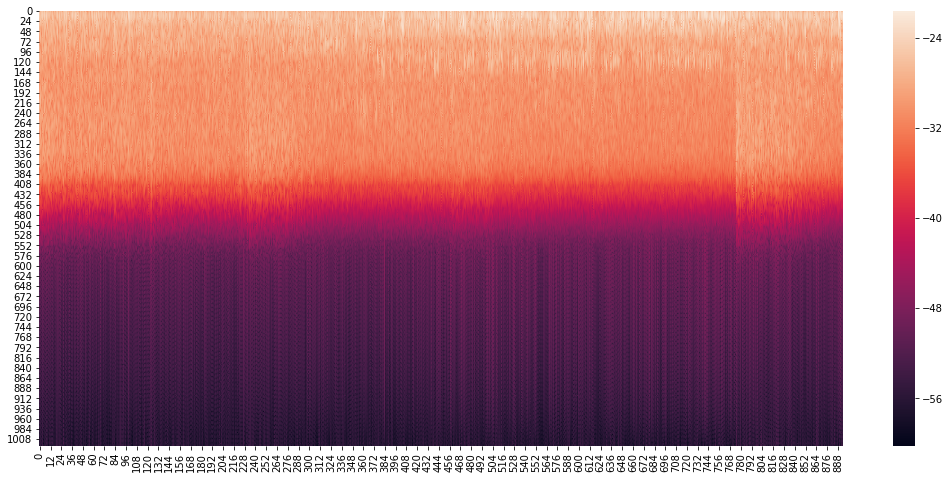

In [201]:
heatmap()

a.2) Calcular la potencia media (entre epochs) para cada frecuencia y graficar la potencia en funcion de la frecuencia para cada canal, como en el ejemplo:

/usr/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


(0, 12)

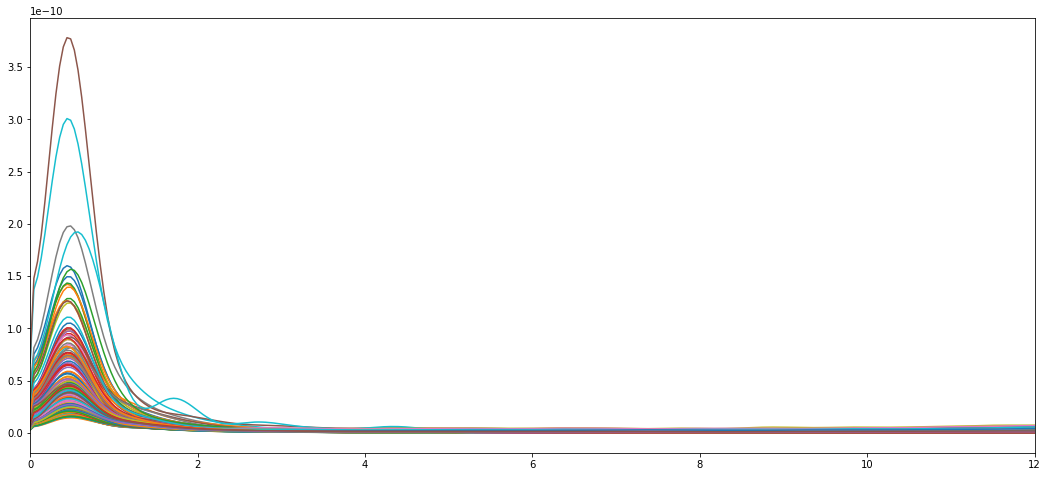

In [102]:
def potencia_media_por_frecuencia(electrodo=0):
    epochs = []
    for epoch in range(len(data)):
        frecuencias, poder_espectral = welch_eeg(data[epoch, electrodo])
        epochs.append(poder_espectral)
    
    # matriz donde las filas son epochs, las columnas frecuencias y los valores poderes espectrales
    matriz = np.stack(epochs)
    medias_de_poderes_espectrales = np.mean(matriz, axis=0)
    plt.plot(frecuencias, medias_de_poderes_espectrales)

for electrodo in range(cant_electrodos):
    potencia_media_por_frecuencia(electrodo)
    
plt.xlim(0, 12)    # set the xlim to xmin, xmax

Generamos una función auxiliar para binnear las frecuencias y la testeamos

In [46]:
def getBanda(frecuencia):
    """ [0, 4, 8, 13, 30, 45]  # Delta, Theta, Alpha, Beta, Gamma """
    res = 0
    for indice, lim_izq in enumerate(bandas):
        if frecuencia >= lim_izq:
            res = indice
        else:
            break
    return res

assert getBanda(1) == 0
assert getBanda(6) == 1
assert getBanda(10) == 2
assert getBanda(15) == 3
assert getBanda(33) == 4
assert getBanda(50) == 5

b) Calcular los valores de cada banda de frecuencia, promediados entre los electrodos (todos) y epochs para cada sujeto.

/usr/lib/python3.6/site-packages/scipy/signal/spectral.py:1633: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


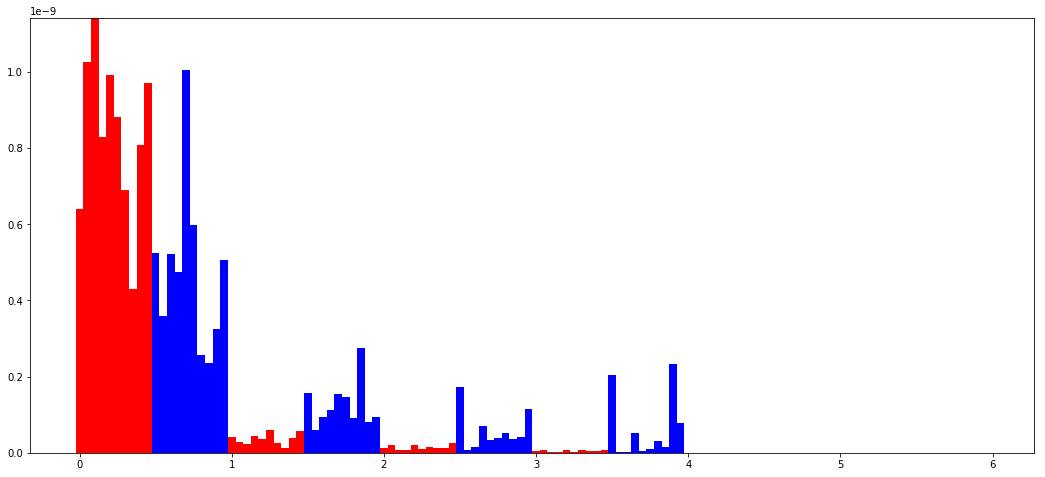

In [115]:
barwidth = 1 / len(allSubjects())

bins_por_sujeto = {}
# for index, filename in enumerate(['dataset/S01.mat', 'dataset/P01.mat']):
for index, filename in enumerate(allSubjects()):
    poderes_por_sujeto = np.zeros(longitud_de_poderes)
    bins = np.zeros(len(bandas))
    cantIteraciones = 0
    subject_data = loadSubject(filename)  # epoch, electrodo, muestra
    
    for epoch in subject_data:
        for num_electrodo in electrodos:
            electrodo = epoch[num_electrodo]
            frecuencias, poder_espectral = welch_eeg(electrodo)
            poderes_por_sujeto += poder_espectral
            cantIteraciones += 1

    # Calculamos el promedio de los poderes espectrales para un sujeto dado, todos los epochs y los
    # electrodos indicados.
    poderes_por_sujeto /= cantIteraciones
    
    for frecuencia, poder in zip(frecuencias, poderes_por_sujeto):
        bins[getBanda(frecuencia)] += poder
        
    bins_por_sujeto[filename] = bins
        
    plt.bar(np.arange(len(bandas)) + index * barwidth, bins, width=barwidth,
           color='red' if 'P' in filename else 'blue', label='bandas')
#     plt.set_xticklabels(nombre_bandas)

c) Tomar la potencia de cada sujeto en la banda Alpha y graficar cada uno de los graficos categóricos de seaborn.

In [196]:
# Separamos en P y S
def get_letter(filename):
    return splitext(split(filename)[1])[0][0]

filenames = [get_letter(fn) for fn in bins_por_sujeto.keys()]
bandas_alpha = [bin[2] for bin in bins_por_sujeto.values()]
bandas_alpha_log = np.log(bandas_alpha)

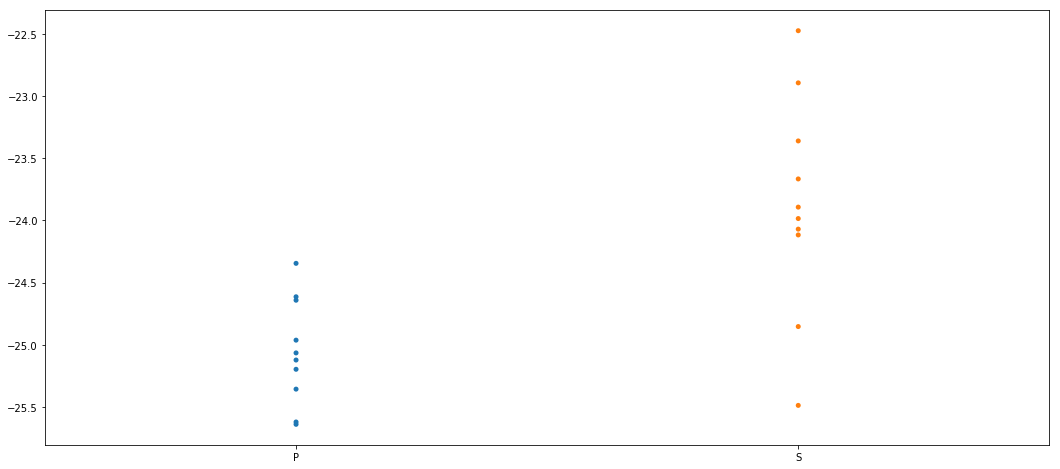

In [178]:
sns.stripplot(x=filenames, y=bandas_alpha_log)

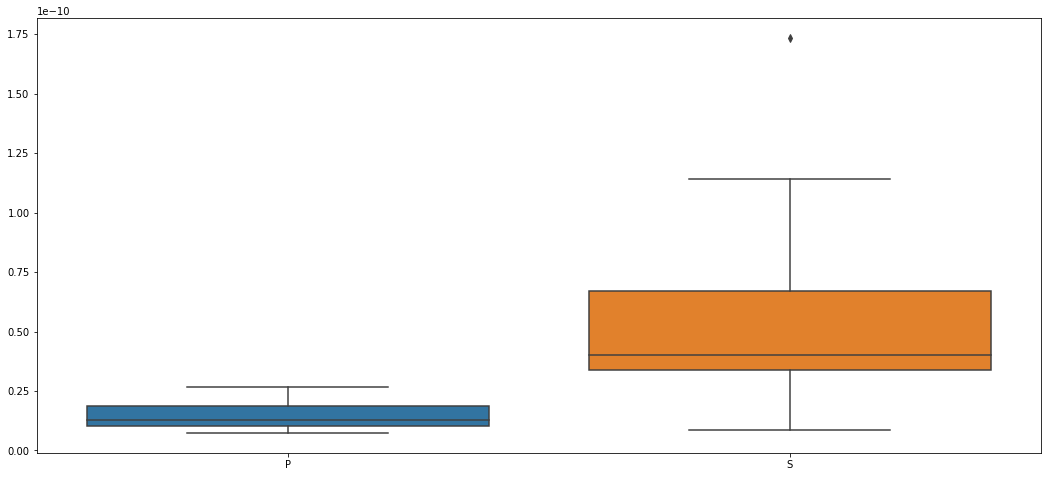

In [176]:
sns.boxplot(x=filenames, y=bandas_alpha)

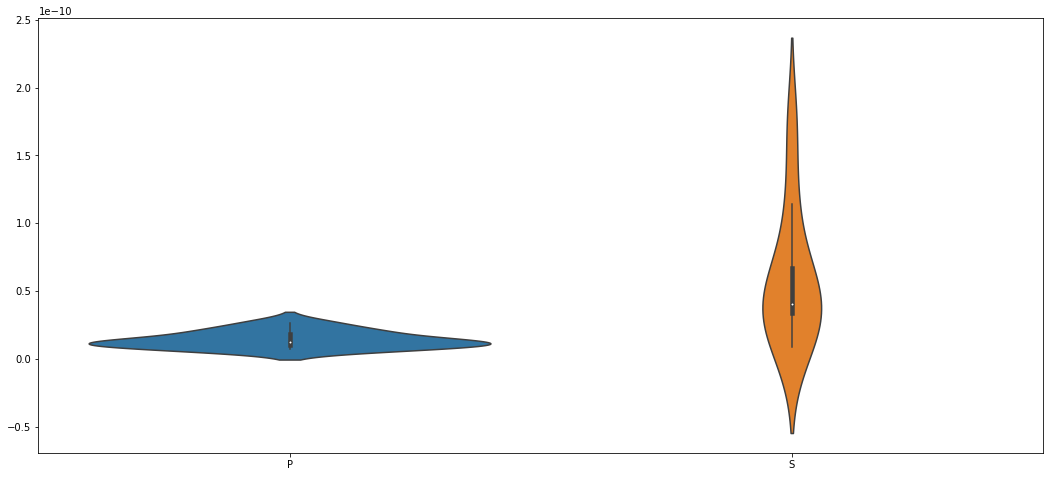

In [175]:
sns.violinplot(x=filenames, y=bandas_alpha)

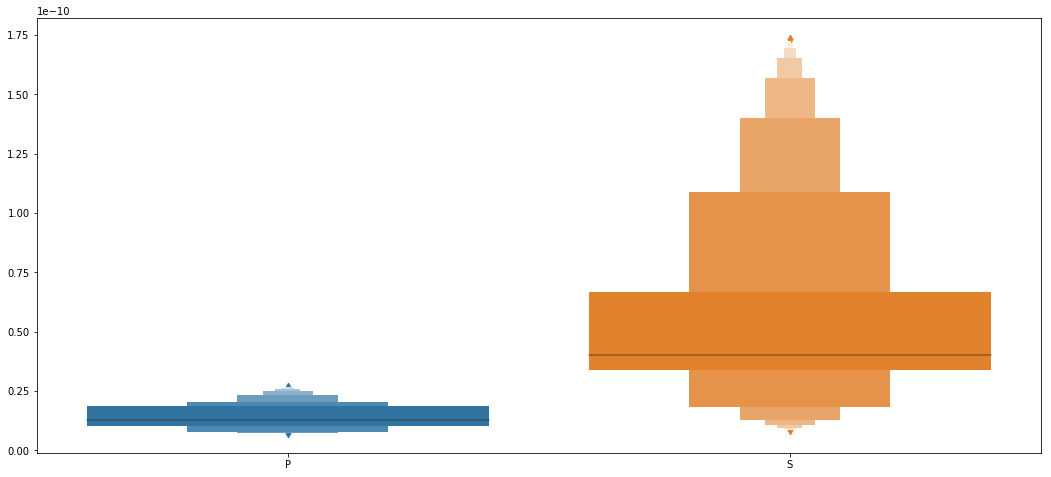

In [179]:
sns.lvplot(x=filenames, y=bandas_alpha)

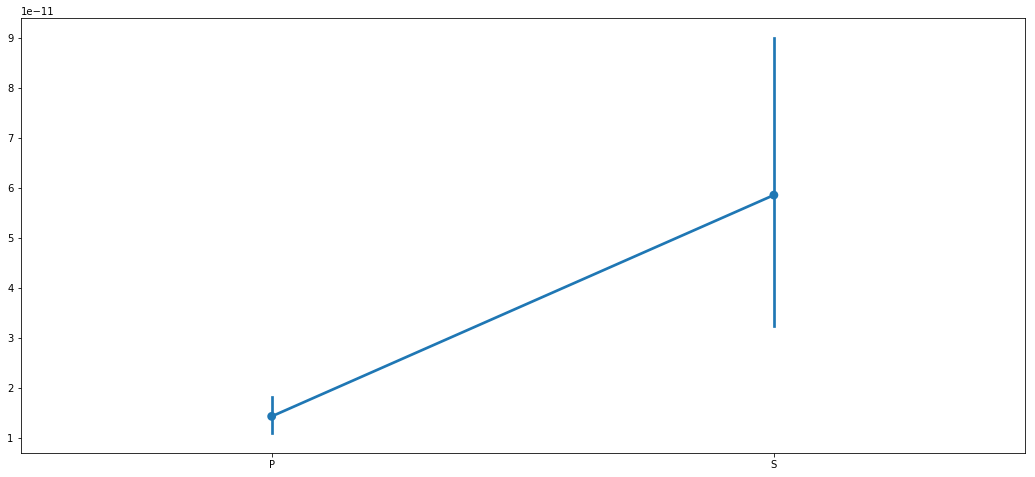

In [180]:
sns.pointplot(x=filenames, y=bandas_alpha)

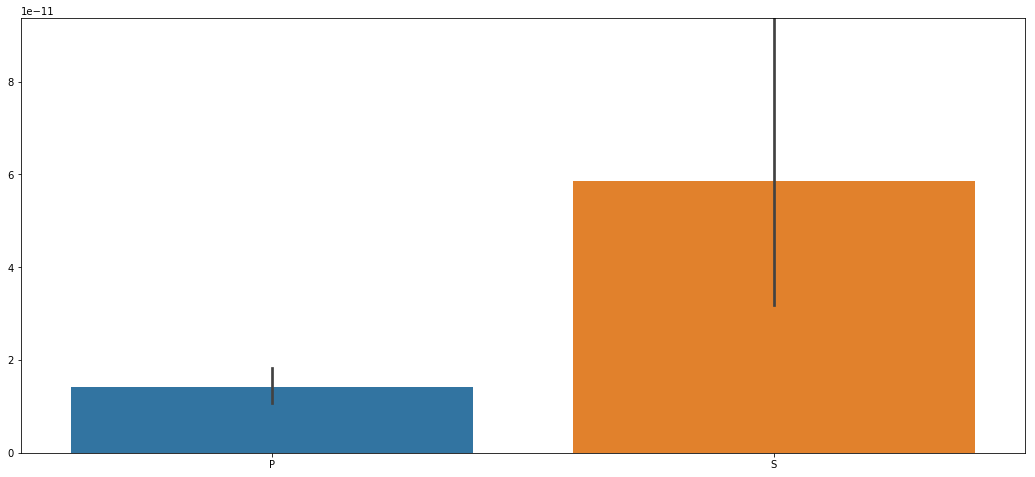

In [181]:
sns.barplot(x=filenames, y=bandas_alpha)

de: https://www.autodeskresearch.com/publications/samestats

One interesting property of our technique is that it can work for visualizations other than 2D scatter plots, and statistical properties besides the standard summary statistics. In the example below each of the datasets start out as a normal distribution of points. The boxplot shown at the bottom is a standard "Tukey Boxplot" which shows the 1st quartile, median, and 3rd quartile values on the "box", and the "whiskers" showing the location of the furthest data points within 1.5 interquartile ranges from the 1st and 3rd quartiles. Boxplots are commonly used to show the distribution of a dataset, and are better than simply showing the mean or median value. However, here we can see as the distribution of points changes, the box-plot remains the same.

Fig 7. Three varying 1D distributions of data, all with the same boxplot representation.
Another way to look at these 1D distributions is to consider a dataset with seven categories (Figure 8, below). The data in each category is shifting overtime, as can clearly be seen in the "Raw" data view, yet the boxplots remain static. Violin plots are a good method for presenting the distribution of a dataset with more detail than is available with a traditional boxplot. This is not to say that using a boxplot is never appropriate, but if you are going to use a boxplot, it is important to make sure the underlying data is distrubuted in a way that important information is not hidden.

d) Para cada banda de frecuencia, graficar según lo elegido en el punto c) y realizar un test estadístico apropiado.

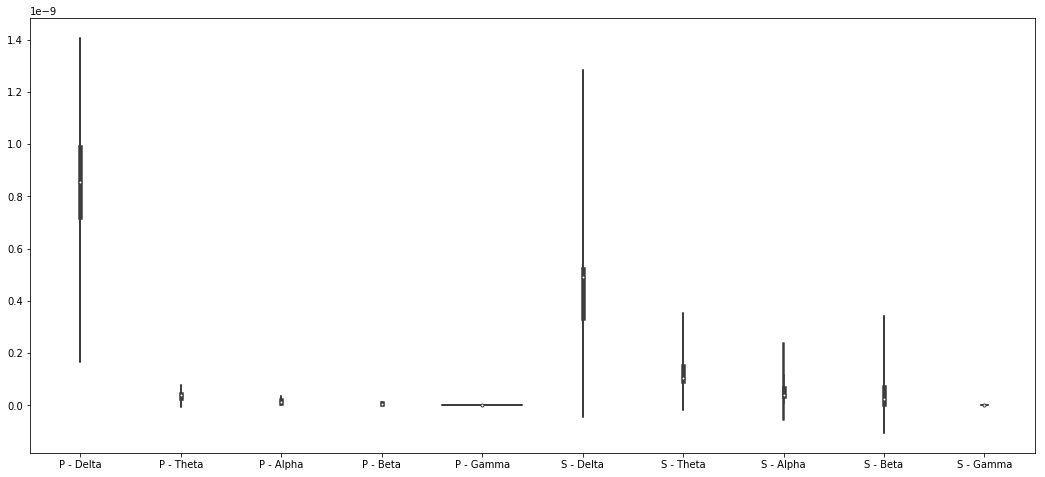

In [202]:
# Agrupamos todos los valores en categoria x bandas ({P|S} * {theta, alpha, beta, gamma, etc})

x, y = [], []
for filename, datapoints in bins_por_sujeto.items():
    letter = get_letter(filename)
    for index, value in enumerate(datapoints):
        try:
            label = letter + ' - ' + nombre_bandas[index]
        except IndexError:
            continue
        else:
            x.append(label)
            y.append(value)
        
sns.violinplot(x=x, y=y)

TODO: t-test

e) Repetir los puntos b) y d) para los valores normalizados.

Al binnear los poderes espectrales por bandas, dividir por la cantidad que cayeron en cada banda
TODO

## 2.2 Análisis de información

a) Computar una medida de información intra-electrodo. Calcular la media entre canales y epochs para cada sujeto. Realizar el gráfico elegido en el punto c) de la sección anterior, acompañado del test estadístico apropiado.

b) Repetir el punto a) para una medida inter-electrodo.